In [5]:
import sys
sys.path.append("../python/")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
from _corner import corner
import pickle
from scipy.stats import gaussian_kde, binned_statistic
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize

Plot posterior and ML estimators

0.40842391788918375 1.0483570385720413 5.939668183834853


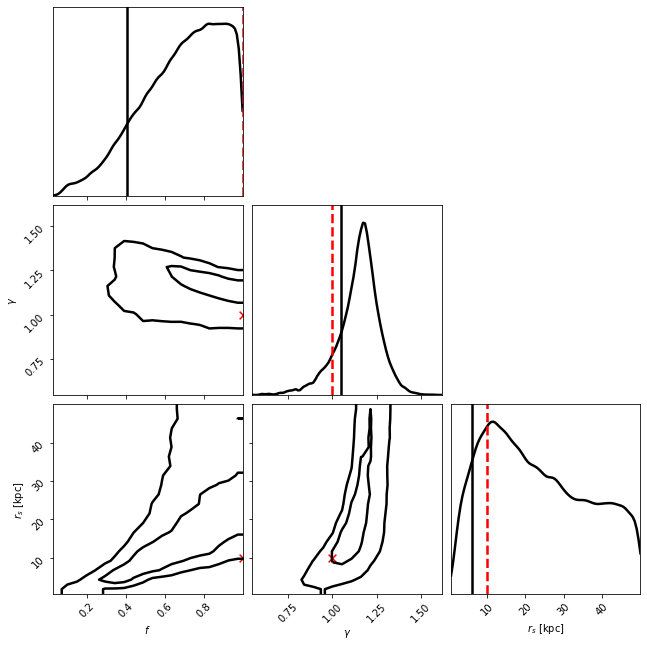

In [2]:
nBDs = 1000; relT = 0.10; relM = 0.10; ex = "ex25"
f_true=1.; rs_true = 10.; gamma_true=1.

_path   = "/hdfs/local/mariacst/exoplanets/results/final_round/"
_file   = open(_path + 
               "likelihood/all_unc/velocity/v200/N%irelT%.2frelM%.2f/like_" %(nBDs, relT, relM) +
               ex + 
               "_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1fv50" %(nBDs, relT, relM, f_true, gamma_true, rs_true),
               "rb") 
like    = pickle.load(_file)
_file   = open(_path + 
               "all_unc/velocity/v200/N%irelT%.2frelM%.2f/posterior_" %(nBDs, relT, relM) +
               ex + 
               "_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1fv50" %(nBDs, relT, relM, f_true, gamma_true, rs_true),
               "rb") 
samples = pickle.load(_file)

smooth=0.5
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth)

# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5) 

ML = samples[np.argmax(like)]
axes[0, 0].axvline(ML[0], ls="-", lw=2.5, color="k"); axes[0, 0].axvline(f_true, color="r", ls="--", lw=2.5)
axes[1, 1].axvline(ML[1], ls="-", lw=2.5, color="k"); axes[1, 1].axvline(gamma_true, color="r", ls="--", lw=2.5)
axes[2, 2].axvline(ML[2], ls="-", lw=2.5, color="k");axes[2, 2].axvline(rs_true, color="r", ls="--", lw=2.5)

axes[1, 0].scatter(f_true, gamma_true, marker="x", color="red", s=60)
axes[2, 0].scatter(f_true, rs_true, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma_true, rs_true, marker="x", color="red", s=60)

axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

print(ML[0], ML[1], ML[2])

In [9]:
def LI(L, samples, bin_n=10, verbose=False):
    """
    For each parameter, construct profile likelihood and return the profile likelihood interval
    (i.e. region where the log Likelihood is within 1 of its maximum value)
    
    """   
    # Create bins in Likelihood vs parameter space, find the max Likelihood 
    # value in each bin and the corresponding parameter values
    x = binned_statistic(samples, -L, 'min', bins=bin_n)[1] 
    y = binned_statistic(samples, -L, 'min', bins=bin_n+1)[0]
    
    # Create Interpolation fanction Likelihood - parameter
    #pdb.set_trace()
    z =  UnivariateSpline(x, y, s=0)
    
    # Find in which points crosses 1sigma horizontal line (where 1 sigma 
    # corresponds to 1/2 -for 1 dof-)
    x_tmin     = np.min(samples)
    epsilon    = 1
    niteration = 0
    logLmin    = np.min(y) + 0.5
    while epsilon > 10**-6 and niteration < 20:
        niteration +=1
        minimum = minimize(lambda x: (z(x)-logLmin)**2, x_tmin,
                           bounds=((np.min(samples), samples[np.argmax(L)]),))
        epsilon = minimum.fun
        x_tmin  = x_tmin*1.1
        _min    = minimum.x
        
    if epsilon < 10**-6:
        LImin = _min[0]
    else:
        LImin = np.min(samples)
        
    x_tmax     = samples[np.argmax(L)]
    epsilon    = 1
    niteration = 0
    while epsilon > 10**-6 and niteration < 25:
        niteration +=1
        maximum = minimize(lambda x: (z(x)-logLmin)**2, x_tmax, 
                           bounds=((samples[np.argmax(L)], np.max(samples)),))
        epsilon  = maximum.fun
        x_tmax  = x_tmax*1.1
        _max    = maximum.x
    
    if epsilon < 10**-6:
        LImax = _max[0]
    else:
        LImax = np.max(samples)

    if verbose==True:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.plot(x, y, color="k", lw=2.5)
        ax.axvline(LImin, color="g"); ax.axvline(LImax, color="g")

    #Return
    return  LImin, LImax

(0.5858713282643522, 49.99819280637635)

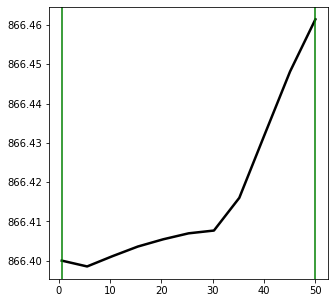

In [13]:
LI_test(like, samples[:, 2], bin_n=10, verbose=True)

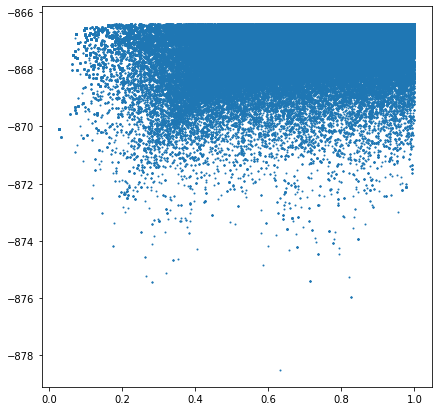

In [11]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000


fig, ax = plt.subplots(1, 1, figsize=(7, 7))
#print(samples[:, 0].shape, like.shape)
ax.scatter(samples[:, 0], like, s=1)

In [6]:
import utils_plots
import imp
imp.reload(utils_plots)
from utils_plots import grid_FSE

../python/utils_plots.py:348: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['5', '10', '20'])


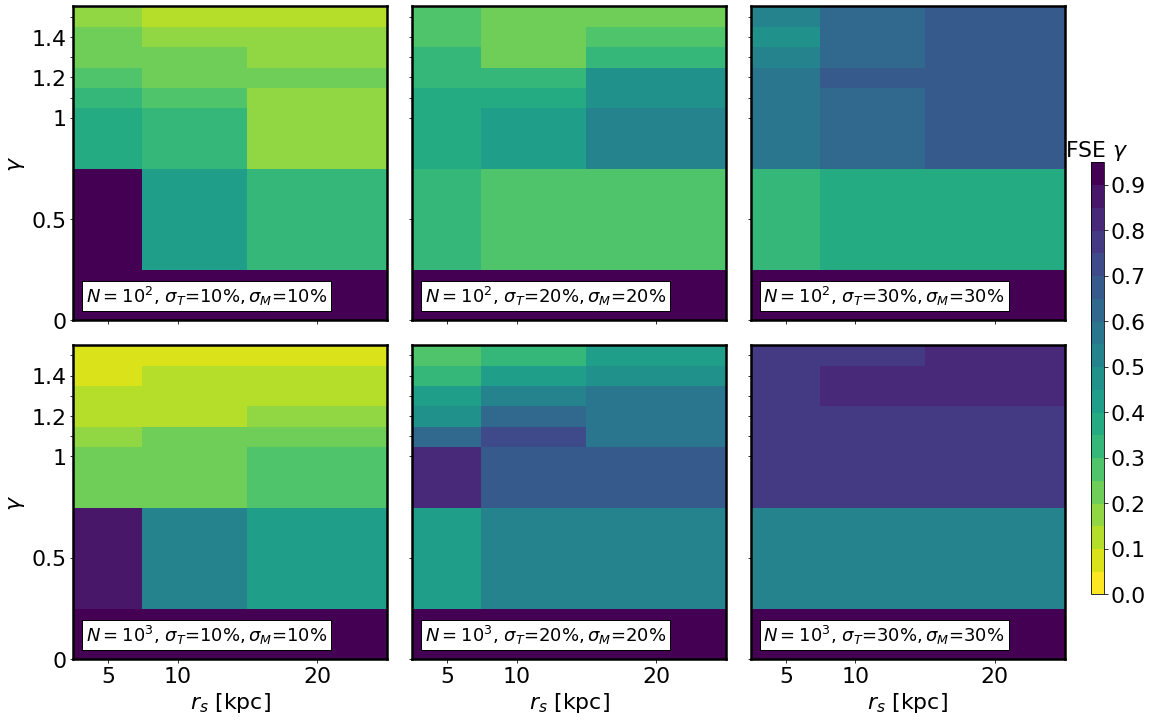

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

path = "/home/mariacst/exoplanets/results/velocity/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex25", ax[0, 0], "median", False, True, True, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex25", ax[0, 1], "median", False, True, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex25", ax[0, 2], "median", False, True, False, False)

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex25", ax[1, 0], "median", False, True, True, True)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex25", ax[1, 1], "median", False, True, False, True)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex25", ax[1, 2], "median", False, True, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title("FSE $\gamma$", size=22.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

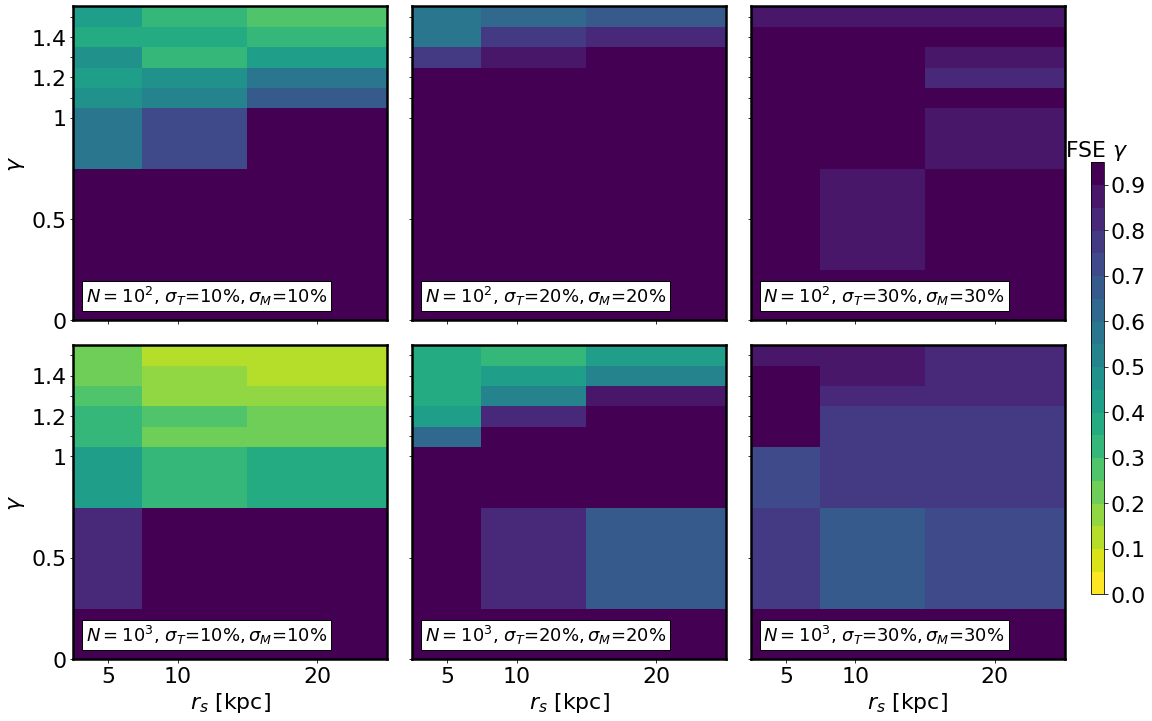

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

path = "/home/mariacst/exoplanets/results/velocity/"
im   = grid_FSE(path, 100, 0.1, 0.1, "ex25", ax[0, 0], "ML", False, True, True, False)
im   = grid_FSE(path, 100, 0.2, 0.2, "ex25", ax[0, 1], "ML", False, True, False, False)
im   = grid_FSE(path, 100, 0.3, 0.3, "ex25", ax[0, 2], "ML", False, True, False, False)

im   = grid_FSE(path, 1000, 0.1, 0.1, "ex25", ax[1, 0], "ML", False, True, True, True)
im   = grid_FSE(path, 1000, 0.2, 0.2, "ex25", ax[1, 1], "ML", False, True, False, True)
im   = grid_FSE(path, 1000, 0.3, 0.3, "ex25", ax[1, 2], "ML", False, True, False, True)

fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.91, 0.2, 0.01, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.set_title("FSE $\gamma$", size=22.)
fig.subplots_adjust(wspace=0.08, hspace=0.08)

In [16]:
def FSE_f_gamma_rs(filepath, nBDs, rel_unc, relM, ex, rank=100, PE="median"):   
    # grid points                                                               
    f     = 1.                                                                      
    rs    = np.array([20.])                                                
    gamma = np.array([1])                         
                                                                                    
    FSE_1 = []; FSE_2 = []; FSE_3 = []                                              
    for _rs in rs:                                                                  
        for _g in gamma:                                                            
            true = [f, _g, _rs]                                                     
            data = np.genfromtxt(filepath + "statistics_" + ex +                    
                                 ("_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1f" 
                                  %(nBDs, rel_unc, relM, f, _g, _rs)), unpack=True)
            if PE=="median":                                                        
                pe = np.array((data[3], data[4], data[5]))                          
            elif PE=="ML":                                                          
                pe = np.array((data[15], data[16], data[17]))                       
            else:                                                                   
                sys.exit("Point estimate not implemented!")                         
            FSE_1.append(np.sqrt(1/rank*np.sum(np.power(pe[0] - true[0], 2)))/true[0])
            if np.abs(_g) < 1e-5:                                                   
                epsilon=1e-4                                                        
            else:                                                                   
                epsilon=0.                                                          
            FSE_2.append(np.sqrt(1/rank*np.sum(np.power(pe[1] - true[1], 2)))/(true[1]+epsilon))
            FSE_3.append(np.sqrt(1/rank*np.sum(np.power(pe[2] - true[2], 2)))/true[2])
                                                                                    
    xi = np.array([2.5, 7.5, 15, 25])                                               
    yi = np.array([0., 0.25, 0.75, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55])             
    xi, yi = np.meshgrid(xi, yi, indexing="ij")                                     
                                                                                    
    zi_1   = np.array(FSE_1).reshape(len(rs), len(gamma))                           
    zi_2   = np.array(FSE_2).reshape(len(rs), len(gamma))                           
    zi_3   = np.array(FSE_3).reshape(len(rs), len(gamma))                           
    # return                                                                        
    return pe, xi, yi, zi_1, zi_2, zi_3

In [31]:
pe, _, _, _, _, _ = FSE_f_gamma_rs(path, 100, 0.1, 0.1, "ex25", rank=100, PE="median")

In [32]:
print (pe.shape, pe[1])

(3, 100) [1.0476 0.942  0.8159 1.2455 1.011  1.1219 1.1283 1.2665 1.3664 0.959
 1.0358 0.8923 1.036  1.1349 0.9497 0.7213 1.0268 1.1965 1.1331 0.9108
 1.2336 1.0369 1.2804 0.9644 0.9902 1.0175 0.6718 1.0662 1.1549 1.2671
 0.8988 0.9748 1.2136 1.0897 1.1343 1.0291 1.0517 1.4166 1.1828 1.0196
 0.9398 0.7995 0.9196 1.1219 1.285  1.0792 0.8853 1.0905 1.018  1.1795
 1.1646 1.0875 1.2354 0.91   1.0746 1.0745 0.9866 0.729  1.0786 0.9108
 0.8468 1.2437 1.1242 1.0392 1.1323 0.9906 0.7748 1.1534 1.0529 1.1469
 1.641  1.0949 1.3548 1.1297 1.1102 1.0804 1.044  1.1837 1.0624 1.0118
 1.0932 1.1077 1.1347 0.8685 1.3373 1.2879 1.1565 1.0628 1.2111 1.1866
 0.7483 1.1276 1.4054 0.7443 1.2084 1.2123 0.9245 1.2064 1.0371 1.1155]


In [33]:
np.sqrt(1/100*np.sum(np.power(pe[1] - 1., 2)))

0.1792928648887066

xvals =  (4.922753073810515e-05, 2.224383319197255)
yvals =  (0.0, 1.0999999999999213)
4.922753073810515e-05 2.224383319197255    -0.42957571067294964 1.0
0.243870576864742 49.99905197279563    0.9165547924228008 1.0
0.0006990402546363517 0.9999905832354677    0.7611694909678874 1.0
0.9861131931492482 0.6619882846653002 9.117964238681903


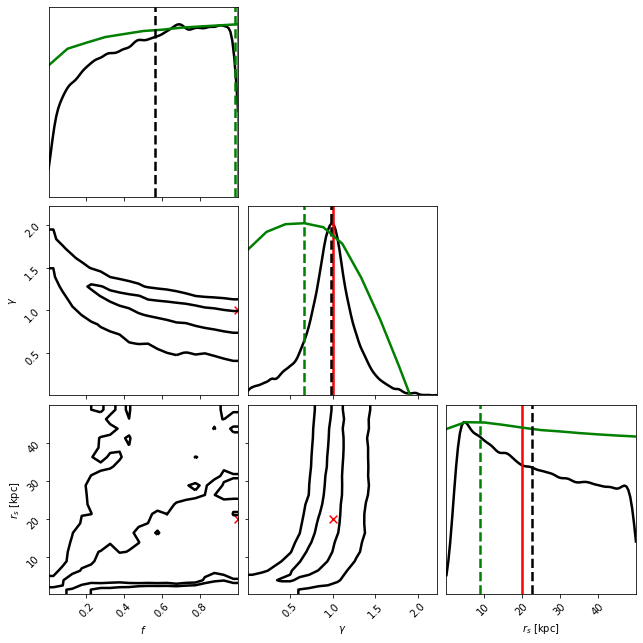

In [6]:
nBDs = 100; relT = 0.10; relM = 0.10; ex = "ex25"
f_true=1.; rs_true = 20.; gamma_true=1.

_path   = "/hdfs/local/mariacst/exoplanets/results/final_round/"
_file   = open(_path + 
               "likelihood/all_unc/velocity/v200/N%irelT%.2frelM%.2f/like_" %(nBDs, relT, relM) +
               ex + 
               "_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1fv32" %(nBDs, relT, relM, f_true, gamma_true, rs_true),
               "rb") 
like    = pickle.load(_file)
_file   = open(_path + 
               "all_unc/velocity/v200/N%irelT%.2frelM%.2f/posterior_" %(nBDs, relT, relM) +
               ex + 
               "_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1fv32" %(nBDs, relT, relM, f_true, gamma_true, rs_true),
               "rb") 
samples = pickle.load(_file)

smooth=0.5
fig, axes = corner(samples, levels=(1-np.exp(-0.5), 1-np.exp(-2)), plot_datapoints=False, 
                   plot_density=False, fill_contours=False, smooth=smooth)

# plot KDE smoothed version of distributions
for axidx, samps in zip([0, 4, 8], samples.T):
    kde   = gaussian_kde(samps)
    xvals = fig.axes[axidx].get_xlim()
    xvals = np.linspace(xvals[0], xvals[1], 100)
    fig.axes[axidx].plot(xvals, kde(xvals)/np.max(kde(xvals)), color="k", lw=2.5) 
    if axidx==4:
        #print(xvals, kde(xvals)/np.max(kde(xvals)))
        xvals = fig.axes[axidx].get_xlim()
        yvals = fig.axes[axidx].get_ylim()
        print("xvals = ", xvals)
        print("yvals = ", yvals)

ML = samples[np.argmax(like)]
axes[0, 0].axvline(ML[0], ls="--", lw=2.5, color="g"); axes[0, 0].axvline(f_true, color="r", ls="-", lw=2.5)
axes[1, 1].axvline(ML[1], ls="--", lw=2.5, color="g"); axes[1, 1].axvline(gamma_true, color="r", ls="-", lw=2.5)
axes[2, 2].axvline(ML[2], ls="--", lw=2.5, color="g"); axes[2, 2].axvline(rs_true, color="r", ls="-", lw=2.5)

axes[1, 1].axvline(0.9748, color="k", ls="--", lw=2.5)
bin_n=10
x = binned_statistic(samples[:, 1], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 1], like, 'max', bins=bin_n+1)[0]
#print(y)
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[1, 1].plot(x, y, ls="-", color="green", lw=2.5)

x = binned_statistic(samples[:, 2], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 2], like, 'max', bins=bin_n+1)[0]
#print(y)
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[2, 2].plot(x, y, ls="-", color="green", lw=2.5)
axes[2, 2].axvline(22.6111, color="k", ls="--", lw=2.5)

x = binned_statistic(samples[:, 0], like, 'max', bins=bin_n)[1] 
y = binned_statistic(samples[:, 0], like, 'max', bins=bin_n+1)[0]
#print(y)
y = y - np.max(y) + 1
print(np.min(x), np.max(x), "  ", np.min(y), np.max(y))
axes[0, 0].plot(x, y, ls="-", color="green", lw=2.5)
axes[0, 0].axvline(0.5637, color="k", ls="--", lw=2.5)

axes[1, 0].scatter(f_true, gamma_true, marker="x", color="red", s=60)
axes[2, 0].scatter(f_true, rs_true, marker="x", color="red", s=60)
axes[2, 1].scatter(gamma_true, rs_true, marker="x", color="red", s=60)

axes[1, 0].set_ylabel(r"$\gamma$")
axes[2, 0].set_xlabel(r"$f$")
axes[2, 0].set_ylabel(r"$r_s$ [kpc]")
axes[2, 1].set_xlabel(r"$\gamma$")
axes[2, 2].set_xlabel(r"$r_s$ [kpc]")

print(ML[0], ML[1], ML[2])

In [63]:
print (pe[:, 31])

[ 0.5637  0.9748 22.6111]


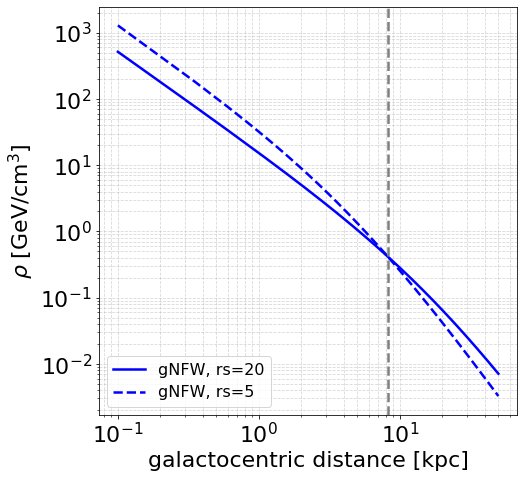

In [68]:
from utils import gNFW_rho

r  = np.linspace(0.1, 50, 200)
R0 = 8.178

rho1 = gNFW_rho(R0, r, [1.5, 20., 0.42])
rho2 = gNFW_rho(R0, r, [1.5, 5., 0.42])

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
ax.plot(r, rho1, color="blue", lw=2.5, label="gNFW, rs=20")
ax.plot(r, rho2, color="blue", lw=2.5, ls="--", label=r"gNFW, rs=5")

ax.axvline(R0, ls="--", color="grey", lw=2.5)

ax.grid(which="both", ls="--", alpha=0.5)
ax.set_ylabel(r"$\rho$ $\rm [GeV/cm^3]$")
ax.set_xlabel("galactocentric distance [kpc]")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(fontsize=16)

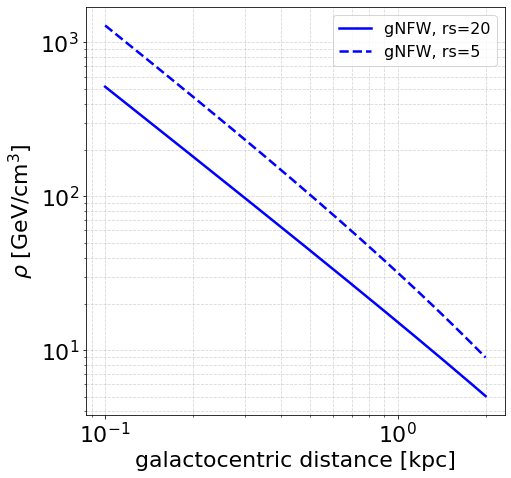

In [69]:
from utils import gNFW_rho

r  = np.linspace(0.1, 2, 200)
R0 = 8.178

rho1 = gNFW_rho(R0, r, [1.5, 20., 0.42])
rho2 = gNFW_rho(R0, r, [1.5, 5., 0.42])

fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
ax.plot(r, rho1, color="blue", lw=2.5, label="gNFW, rs=20")
ax.plot(r, rho2, color="blue", lw=2.5, ls="--", label=r"gNFW, rs=5")

#ax.axvline(R0, ls="--", color="grey", lw=2.5)

ax.grid(which="both", ls="--", alpha=0.5)
ax.set_ylabel(r"$\rho$ $\rm [GeV/cm^3]$")
ax.set_xlabel("galactocentric distance [kpc]")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(fontsize=16)

In [16]:
def FSE_f(filepath, nBDs, rel_unc, relM, ex, _g, _rs, rank=100, PE="median"):   
    # grid points                                                               
    f     = 1.                                                                      
    rs    = np.array([20.])                                                
    gamma = np.array([1])                         
                                                                                    
    FSE_1 = []; FSE_2 = []; FSE_3 = []                                              
   
            
    true = [f, _g, _rs]                                                     
    data = np.genfromtxt(filepath + "statistics_" + ex +                    
                         ("_N%i_relunc%.2f_relM%.2f_f%.1fgamma%.1frs%.1f" 
                          %(nBDs, rel_unc, relM, f, _g, _rs)), unpack=True)
    if PE=="median":                                                        
        pe = np.array((data[3], data[4], data[5]))                          
    elif PE=="ML":                                                          
        pe = np.array((data[15], data[16], data[17]))                       
    else:                                                                   
        sys.exit("Point estimate not implemented!")                         
    FSE_1.append((pe[0] - true[0])/true[0])
    if np.abs(_g) < 1e-5:                                                   
        epsilon=1e-4                                                        
    else:                                                                   
        epsilon=0.                                                          
    FSE_2.append((pe[1] - true[1])/(true[1]+epsilon))
    FSE_3.append((pe[2] - true[2])/true[2])
                                                                                                             
    # return                                                                        
    return FSE_1, FSE_2, FSE_3

Text(0.5, 0, '$\\frac{\\gamma^{true}-\\gamma^{reconst.}}{\\gamma^{true}}$')

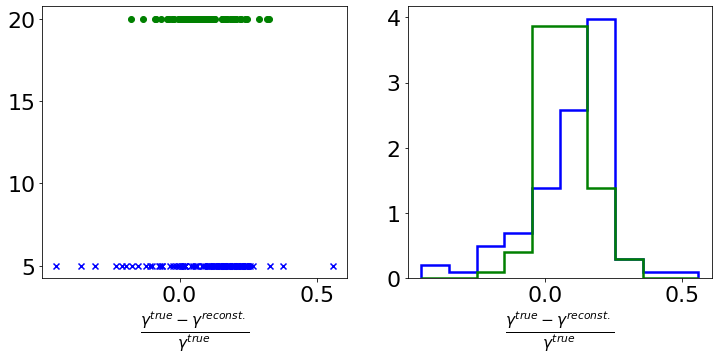

In [30]:
_, FSE_2_5, _  = FSE_f(path, 100, 0.1, 0.1, "ex25", 1.5, 5., rank=100, PE="median")
_, FSE_2_20, _ = FSE_f(path, 100, 0.1, 0.1, "ex25", 1.5, 20., rank=100, PE="median")


fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(FSE_2_5, np.ones(np.shape(FSE_2_5))*5., marker="x", color="blue")
ax[0].scatter(FSE_2_20, np.ones(np.shape(FSE_2_20))*20, marker="o", color="green")

_, bins, _= ax[1].hist(FSE_2_5, color="blue", linewidth=2.5, histtype="step", density=True) 
# tendría que normalizarlo con respecto a 1!!!!
ax[1].hist(FSE_2_20, color="green", linewidth=2.5, histtype="step", bins=bins, density=True)

ax[0].set_xlabel(r"$\frac{\gamma^{true}-\gamma^{reconst.}}{\gamma^{true}}$")
ax[1].set_xlabel(r"$\frac{\gamma^{true}-\gamma^{reconst.}}{\gamma^{true}}$")

## Starting from the beginning...

In [3]:
import mock_generation
import imp
imp.reload(mock_generation)

from mock_generation import mock_population_all
from utils import temperature_withDM, heat
from scipy.interpolate import griddata
from astropy.constants import R_jup, M_sun

**Only uncertainties in T**

In [4]:
nBDs = 100; relT=0.1; 
f_true=1.; gamma_true=1.5; rs_true=20.;
rho0=0.42

def residual(p, robs, Tobs, sigma_Tobs, heat_int, mass):                   
    f, gamma, rs = p                                                            
    Tmodel = temperature_withDM(robs, heat_int, f=f, M=mass*M_sun.value,        
                                parameters=[gamma, rs, rho0])                   
    return -0.5*np.sum(((Tmodel-Tobs)/sigma_Tobs)**2.)

In [18]:
#np.random.seed(21)
robs, Tobs, sigmaTobs, mass, ages = mock_population_all(nBDs, relT, 0., 0., 0., f_true, gamma_true, 
                                                        rs_true, rho0_true=rho0) 

# Load theoretical cooling model
path = "./data/"                                                                
data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)            
points = np.transpose(data[0:2, :])                                             
values = data[2]  
# calculate predictic intrinsic heat flow for mock BDs                         
xi = np.transpose(np.asarray([ages, mass]))                                     
Teff     = griddata(points, values, xi)                                         
heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)

In [33]:
relT

0.1

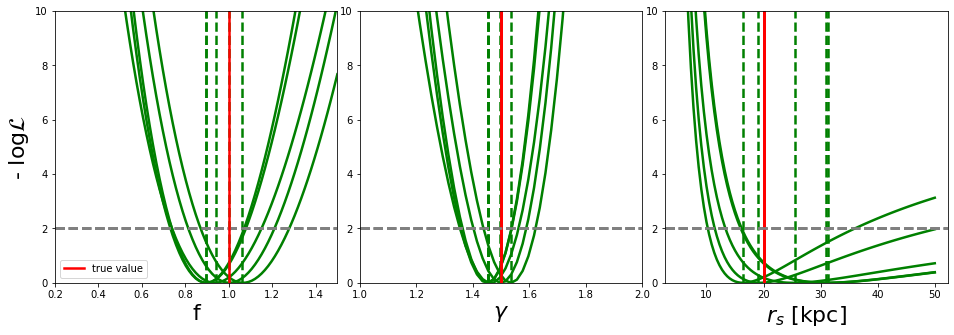

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

for k in range(5):
    
    #np.random.seed(21)
    robs, Tobs, sigmaTobs, mass, ages = mock_population_all(nBDs, relT, 0., 0., 0., f_true, gamma_true, 
                                                            rs_true, rho0_true=rho0) 
    
    # Load theoretical cooling model
    path = "./data/"                                                                
    data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)            
    points = np.transpose(data[0:2, :])                                             
    values = data[2]  
    # calculate predictic intrinsic heat flow for mock BDs                         
    xi = np.transpose(np.asarray([ages, mass]))                                     
    Teff     = griddata(points, values, xi)                                         
    heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
    
    Npoints = 100
    
    #ax[0].set_title("Vary $f$")
    f      = np.linspace(0, 1.5, Npoints)
    like_f = np.zeros(Npoints)
    for i in range(Npoints):
        like_f[i] = residual([f[i], gamma_true, rs_true], robs, Tobs, sigmaTobs, heat_int, mass)
    ax[0].plot(f, -like_f+np.max(like_f), color="green", lw=2.5); ax[0].axvline(f[np.argmax(like_f)], color="green", lw=2.5, ls="--")
    ax[0].set_ylim(0, 10); ax[0].set_xlim(0.2, 1.5)
    ax[0].axhline(2, color="grey", ls="--", lw=2.5)
    
    #ax[1].set_title("Vary $\gamma$")
    gamma      = np.linspace(0, 2., Npoints)
    like_gamma = np.zeros(Npoints)
    for i in range(Npoints):
        like_gamma[i] = residual([f_true, gamma[i], rs_true], robs, Tobs, sigmaTobs, heat_int, mass)
    ax[1].plot(gamma, -like_gamma+np.max(like_gamma), color="green", lw=2.5); 
    ax[1].axvline(gamma[np.argmax(like_gamma)], color="green", lw=2.5, ls="--"); 
    ax[1].axvline(gamma_true, color="red", lw=2.5); ax[1].set_ylim(0, 10); ax[1].set_xlim(1., 2.)
    ax[1].axhline(2, color="grey", ls="--", lw=2.5)
    
    #ax[2].set_title("Vary $r_s$")
    rs      = np.linspace(5., 50., Npoints)
    like_rs = np.zeros(Npoints)
    for i in range(Npoints):
        like_rs[i] = residual([f_true, gamma_true, rs[i]], robs, Tobs, sigmaTobs, heat_int, mass)
    ax[2].plot(rs, -like_rs+np.max(like_rs), color="green", lw=2.5); 
    ax[2].axvline(rs[np.argmax(like_rs)], color="green", lw=2.5, ls="--"); 
    ax[2].axvline(rs_true, color="red", lw=2.5); ax[2].set_ylim(0, 10)
    ax[2].axhline(2, color="grey", ls="--", lw=2.5)

ax[0].axvline(f_true, color="red", lw=2.5, label="true value")
ax[0].legend()
ax[0].set_ylabel(r"- log$\mathcal{L}$", fontsize=22)
ax[0].set_xlabel("f", fontsize=22)
ax[1].set_xlabel(r"$\gamma$", fontsize=22)
ax[2].set_xlabel(r"$r_s$ [kpc]", fontsize=22)
fig.subplots_adjust(wspace=0.08)

fig.savefig("logL_relT0.10_relX0.0.pdf", bbox_inches="tight")

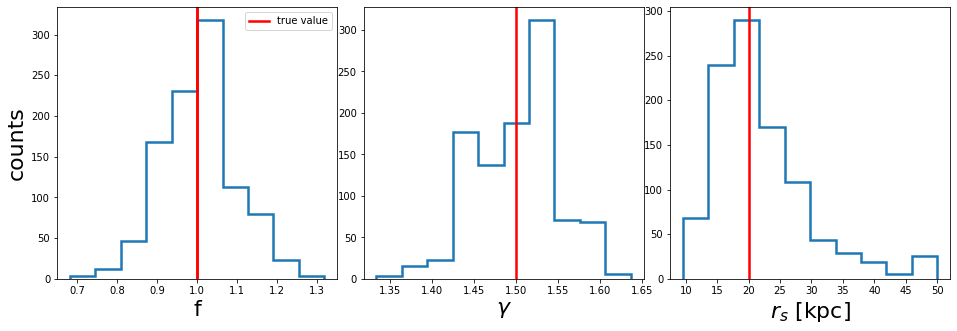

In [31]:
f_ML, gamma_ML, rs_ML = np.genfromtxt("../python/checks/check_likelihood_onlyTunc.dat", unpack=True)
    
fig, ax = plt.subplots(1, 3, figsize=(16, 5))

ax[0].hist(f_ML, histtype="step", linewidth=2.5); ax[1].hist(gamma_ML, histtype="step", linewidth=2.5); 
ax[2].hist(rs_ML, histtype="step", linewidth=2.5);
ax[0].axvline(f_true, color="red", lw=2.5); ax[1].axvline(gamma_true, color="red", lw=2.5);
ax[2].axvline(rs_true, color="red", lw=2.5);

ax[0].axvline(f_true, color="red", lw=2.5, label="true value")
ax[0].legend()
ax[0].set_ylabel(r"counts", fontsize=22)
ax[0].set_xlabel("f", fontsize=22)
ax[1].set_xlabel(r"$\gamma$", fontsize=22)
ax[2].set_xlabel(r"$r_s$ [kpc]", fontsize=22)
fig.subplots_adjust(wspace=0.095)

fig.savefig("histML_relT0.10_relX0.0.pdf", bbox_inches="tight")

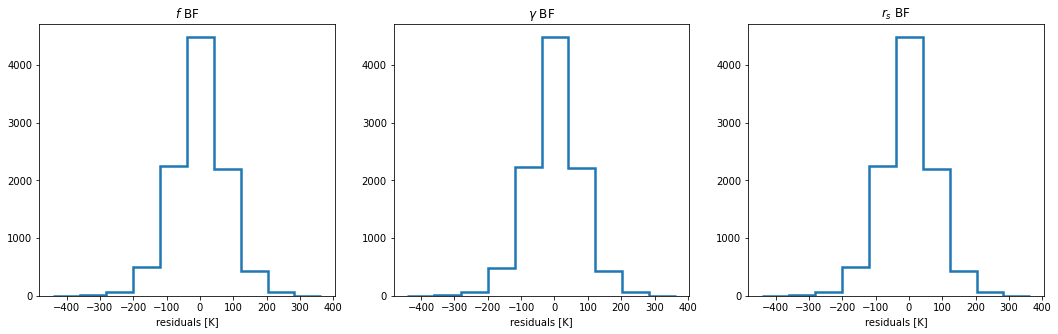

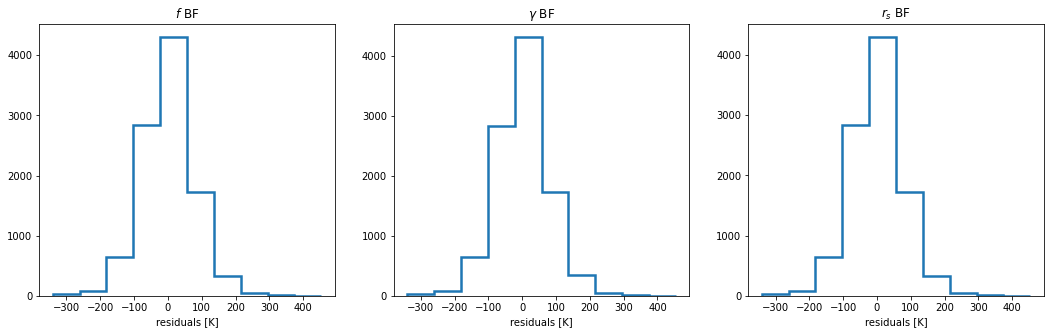

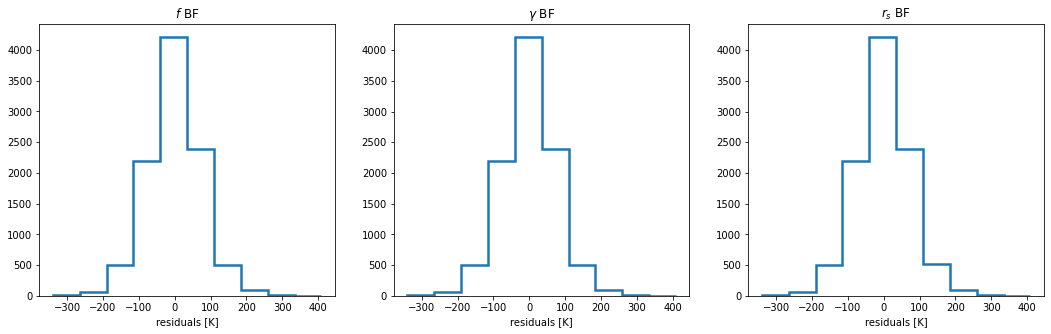

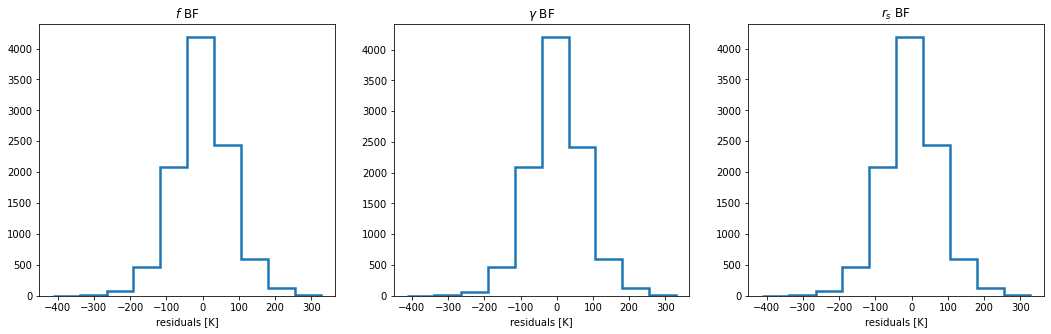

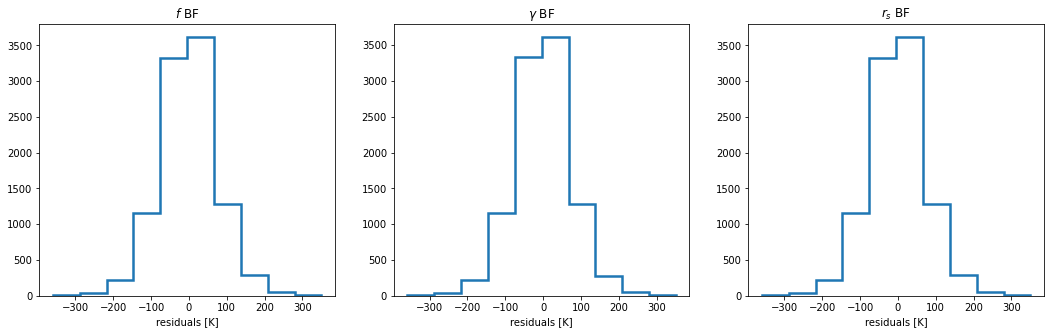

In [10]:
for k in range(5):
    
    #np.random.seed(21)
    robs, Tobs, sigmaTobs, mass, ages = mock_population_all(10000, relT, 0., 0., 0., f_true, gamma_true, 
                                                            rs_true, rho0_true=rho0) 
    
    # Load theoretical cooling model
    path = "./data/"                                                                
    data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)            
    points = np.transpose(data[0:2, :])                                             
    values = data[2]  
    # calculate predictic intrinsic heat flow for mock BDs                         
    xi = np.transpose(np.asarray([ages, mass]))                                     
    Teff     = griddata(points, values, xi)                                         
    heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
    
    Npoints = 100
    
    f          = np.linspace(0, 1.5, Npoints)
    gamma      = np.linspace(0, 2., Npoints)
    rs         = np.linspace(5., 50., Npoints)
    
    like_f     = np.zeros(Npoints)
    like_gamma = np.zeros(Npoints)
    like_rs    = np.zeros(Npoints)
    
    for i in range(Npoints):
        like_f[i]     = residual([f[i], gamma_true, rs_true], robs, Tobs, sigmaTobs, heat_int, mass)
        like_gamma[i] = residual([f_true, gamma[i], rs_true], robs, Tobs, sigmaTobs, heat_int, mass)
        like_rs[i]   = residual([f_true, gamma_true, rs[i]], robs, Tobs, sigmaTobs, heat_int, mass)
    
    f_ML     = f[np.argmax(like_f)]
    gamma_ML = gamma[np.argmax(like_gamma)]
    rs_ML    = rs[np.argmax(like_rs)]
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    ax[0].set_title("$f$ BF")     
    Tmodel = temperature_withDM(robs, heat_int, f=f_ML, M=mass*M_sun.value, 
                                parameters=[gamma_true, rs_true, 0.42]) 
    ax[0].hist((Tobs-Tmodel), histtype="step", linewidth=2.5);
    ax[0].set_xlabel("residuals [K]")
    
    ax[1].set_title("$\gamma$ BF")
    Tmodel = temperature_withDM(robs, heat_int, f=f_true, M=mass*M_sun.value, 
                                parameters=[gamma_ML, rs_true, 0.42]) 
    ax[1].hist((Tobs-Tmodel), histtype="step", linewidth=2.5);
    ax[1].set_xlabel("residuals [K]")
    
    ax[2].set_title("$r_s$ BF")
    Tmodel = temperature_withDM(robs, heat_int, f=f_true, M=mass*M_sun.value, 
                                parameters=[gamma_true, rs_ML, 0.42]) 
    ax[2].hist((Tobs-Tmodel), histtype="step", linewidth=2.5);
    ax[2].set_xlabel("residuals [K]")

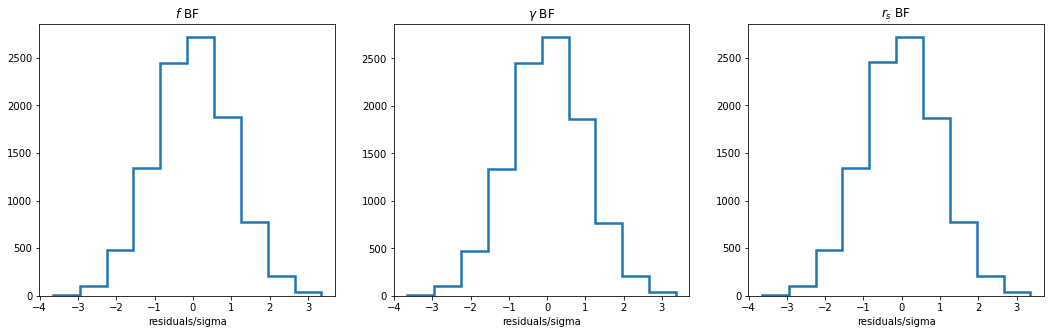

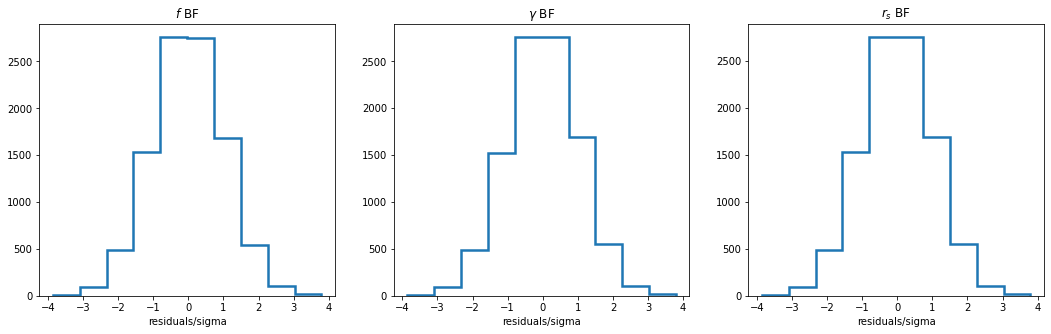

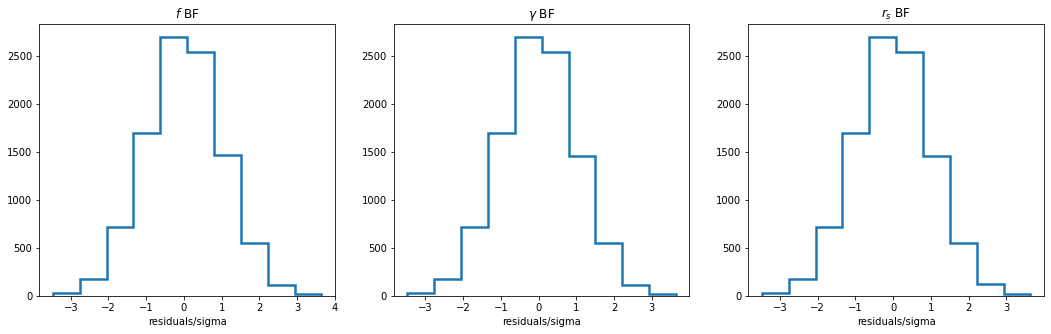

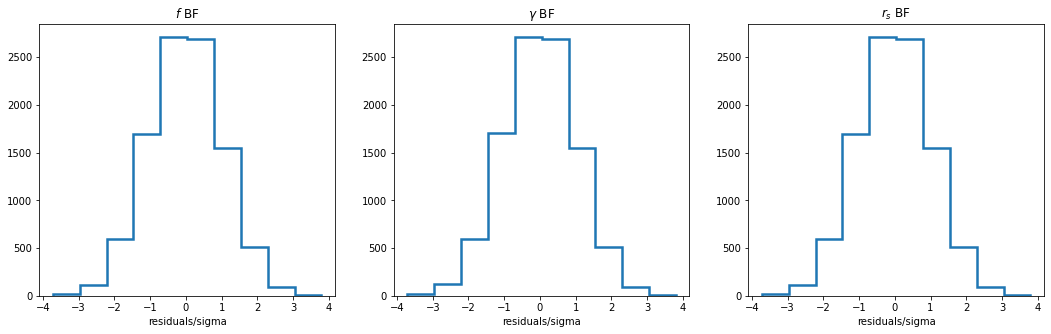

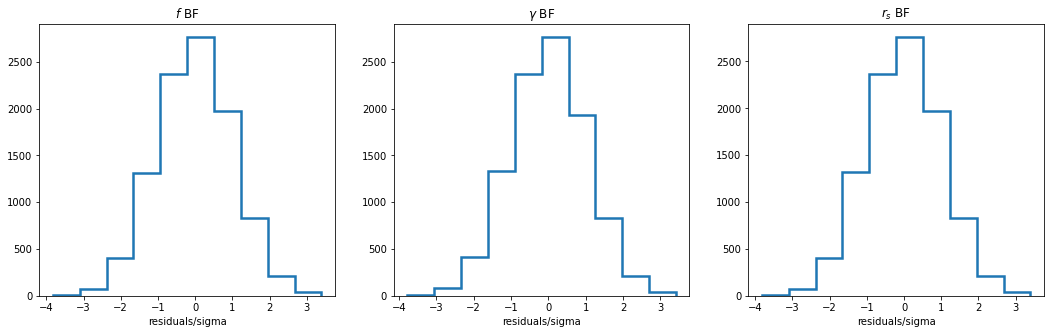

In [7]:
for k in range(5):
    
    #np.random.seed(21)
    robs, Tobs, sigmaTobs, mass, ages = mock_population_all(10000, relT, 0., 0., 0., f_true, gamma_true, 
                                                            rs_true, rho0_true=rho0) 
    
    # Load theoretical cooling model
    path = "./data/"                                                                
    data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)            
    points = np.transpose(data[0:2, :])                                             
    values = data[2]  
    # calculate predictic intrinsic heat flow for mock BDs                         
    xi = np.transpose(np.asarray([ages, mass]))                                     
    Teff     = griddata(points, values, xi)                                         
    heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
    
    Npoints = 100
    
    f          = np.linspace(0, 1.5, Npoints)
    gamma      = np.linspace(0, 2., Npoints)
    rs         = np.linspace(5., 50., Npoints)
    
    like_f     = np.zeros(Npoints)
    like_gamma = np.zeros(Npoints)
    like_rs    = np.zeros(Npoints)
    
    for i in range(Npoints):
        like_f[i]     = residual([f[i], gamma_true, rs_true], robs, Tobs, sigmaTobs, heat_int, mass)
        like_gamma[i] = residual([f_true, gamma[i], rs_true], robs, Tobs, sigmaTobs, heat_int, mass)
        like_rs[i]   = residual([f_true, gamma_true, rs[i]], robs, Tobs, sigmaTobs, heat_int, mass)
    
    f_ML     = f[np.argmax(like_f)]
    gamma_ML = gamma[np.argmax(like_gamma)]
    rs_ML    = rs[np.argmax(like_rs)]
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    ax[0].set_title("$f$ BF")     
    Tmodel = temperature_withDM(robs, heat_int, f=f_ML, M=mass*M_sun.value, 
                                parameters=[gamma_true, rs_true, 0.42]) 
    ax[0].hist((Tobs-Tmodel)/sigmaTobs, histtype="step", linewidth=2.5);
    ax[0].set_xlabel("residuals/sigma")
    
    ax[1].set_title("$\gamma$ BF")
    Tmodel = temperature_withDM(robs, heat_int, f=f_true, M=mass*M_sun.value, 
                                parameters=[gamma_ML, rs_true, 0.42]) 
    ax[1].hist((Tobs-Tmodel)/sigmaTobs, histtype="step", linewidth=2.5);
    ax[1].set_xlabel("residuals/sigma")
    
    ax[2].set_title("$r_s$ BF")
    Tmodel = temperature_withDM(robs, heat_int, f=f_true, M=mass*M_sun.value, 
                                parameters=[gamma_true, rs_ML, 0.42]) 
    ax[2].hist((Tobs-Tmodel)/sigmaTobs, histtype="step", linewidth=2.5);
    ax[2].set_xlabel("residuals/sigma")

**Adding uncertainties on Mass, Age and Galactocentric distance**

In [12]:
nBDs = 100; relT=0.1; 
f_true=1.; gamma_true=1.5; rs_true=20.;
rho0=0.42

In [9]:
#np.random.seed(21)
robs, Tobs, sigmaTobs, mass, ages = mock_population_all(nBDs, relT, 0.1, 0.1, 0.1, f_true, gamma_true, 
                                                        rs_true, rho0_true=rho0) 

# Load theoretical cooling model
path = "./data/"                                                                
data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)            
points = np.transpose(data[0:2, :])                                             
values = data[2]  
# calculate predictic intrinsic heat flow for mock BDs                         
xi = np.transpose(np.asarray([ages, mass]))                                     
Teff     = griddata(points, values, xi)                                         
heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)

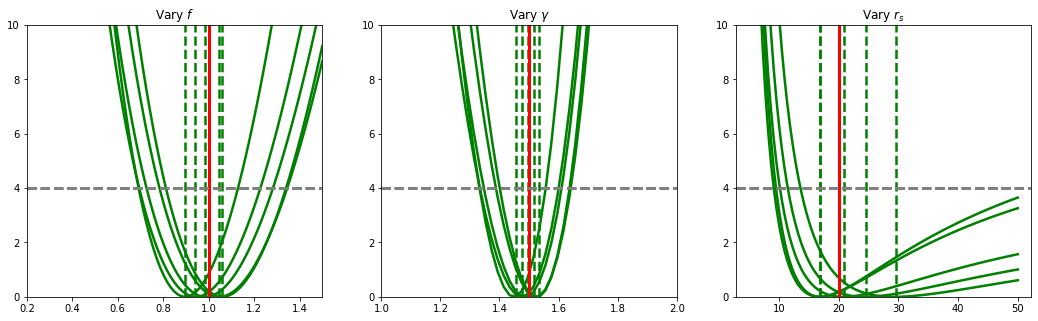

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for k in range(5):
    
    #np.random.seed(21)
    robs, Tobs, sigmaTobs, mass, ages = mock_population_all(nBDs, relT, 0.1, 0.1, 0.1, f_true, gamma_true, 
                                                            rs_true, rho0_true=rho0) 
    
    # Load theoretical cooling model
    path = "./data/"                                                                
    data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)            
    points = np.transpose(data[0:2, :])                                             
    values = data[2]  
    # calculate predictic intrinsic heat flow for mock BDs                         
    xi = np.transpose(np.asarray([ages, mass]))                                     
    Teff     = griddata(points, values, xi)                                         
    heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
    
    Npoints = 100
    
    ax[0].set_title("Vary $f$")
    f      = np.linspace(0, 1.5, Npoints)
    like_f = np.zeros(Npoints)
    for i in range(Npoints):
        like_f[i] = residual([f[i], gamma_true, rs_true], robs, Tobs, sigmaTobs, heat_int, mass)
    ax[0].plot(f, -like_f+np.max(like_f), color="green", lw=2.5); ax[0].axvline(f[np.argmax(like_f)], color="green", lw=2.5, ls="--")
    ax[0].axvline(f_true, color="red", lw=2.5); ax[0].set_ylim(0, 10); ax[0].set_xlim(0.2, 1.5)
    ax[0].axhline(4, color="grey", ls="--", lw=2.5)
    
    
    ax[1].set_title("Vary $\gamma$")
    gamma      = np.linspace(0, 2., Npoints)
    like_gamma = np.zeros(Npoints)
    for i in range(Npoints):
        like_gamma[i] = residual([f_true, gamma[i], rs_true], robs, Tobs, sigmaTobs, heat_int, mass)
    ax[1].plot(gamma, -like_gamma+np.max(like_gamma), color="green", lw=2.5); 
    ax[1].axvline(gamma[np.argmax(like_gamma)], color="green", lw=2.5, ls="--"); 
    ax[1].axvline(gamma_true, color="red", lw=2.5); ax[1].set_ylim(0, 10); ax[1].set_xlim(1., 2.)
    ax[1].axhline(4, color="grey", ls="--", lw=2.5)
    
    ax[2].set_title("Vary $r_s$")
    rs      = np.linspace(5., 50., Npoints)
    like_rs = np.zeros(Npoints)
    for i in range(Npoints):
        like_rs[i] = residual([f_true, gamma_true, rs[i]], robs, Tobs, sigmaTobs, heat_int, mass)
    ax[2].plot(rs, -like_rs+np.max(like_rs), color="green", lw=2.5); 
    ax[2].axvline(rs[np.argmax(like_rs)], color="green", lw=2.5, ls="--"); 
    ax[2].axvline(rs_true, color="red", lw=2.5); ax[2].set_ylim(0, 10)
    ax[2].axhline(4, color="grey", ls="--", lw=2.5)

Text(0.5, 0, '$r_s$ [kpc]')

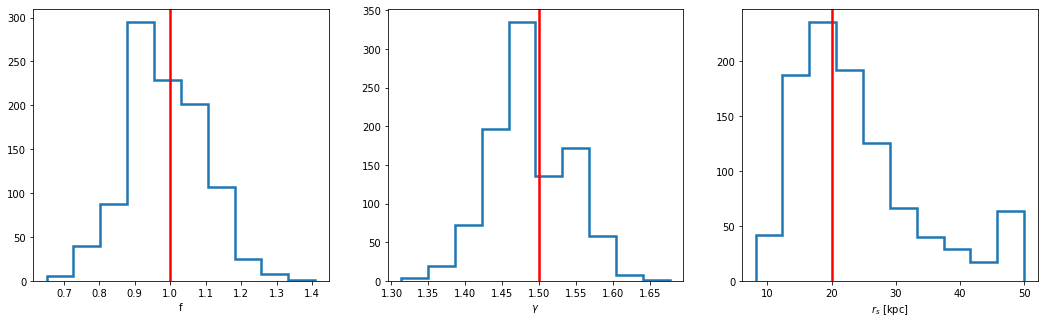

In [9]:
f_ML, gamma_ML, rs_ML = np.genfromtxt("../python/checks/check_likelihood_unc0.1.dat", unpack=True)
    
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(f_ML, histtype="step", linewidth=2.5); ax[1].hist(gamma_ML, histtype="step", linewidth=2.5); 
ax[2].hist(rs_ML, histtype="step", linewidth=2.5);
ax[0].axvline(f_true, color="red", lw=2.5); ax[1].axvline(gamma_true, color="red", lw=2.5);
ax[2].axvline(rs_true, color="red", lw=2.5);

ax[0].set_xlabel("f"); ax[1].set_xlabel(r"$\gamma$"); ax[2].set_xlabel("$r_s$ [kpc]")

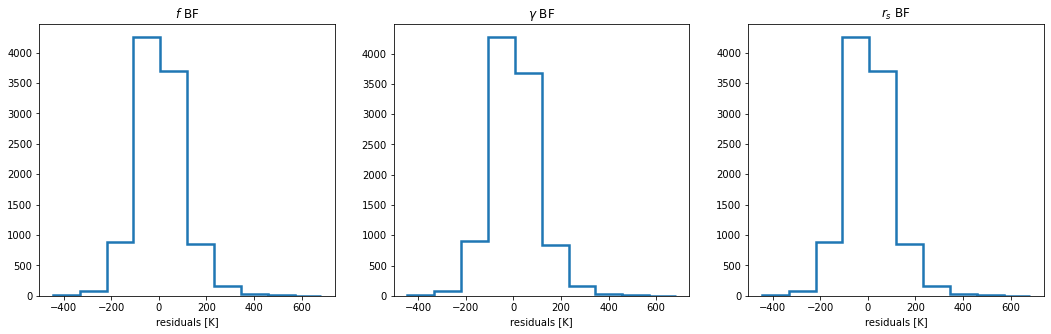

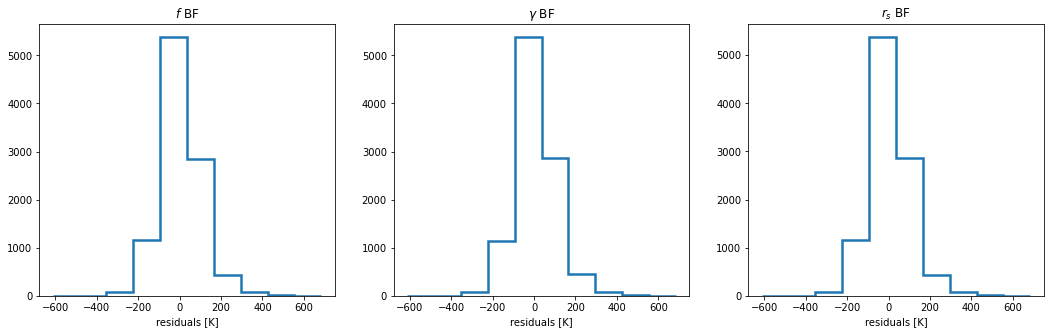

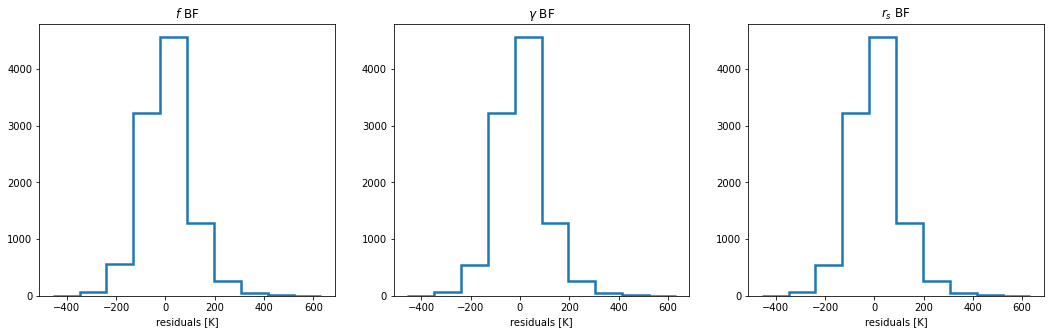

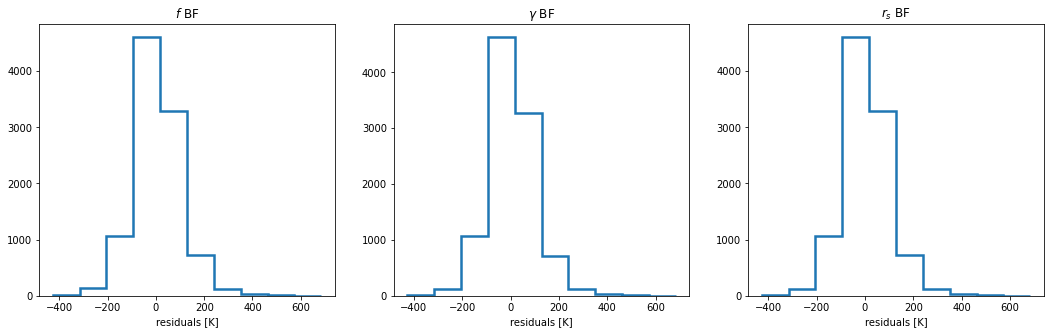

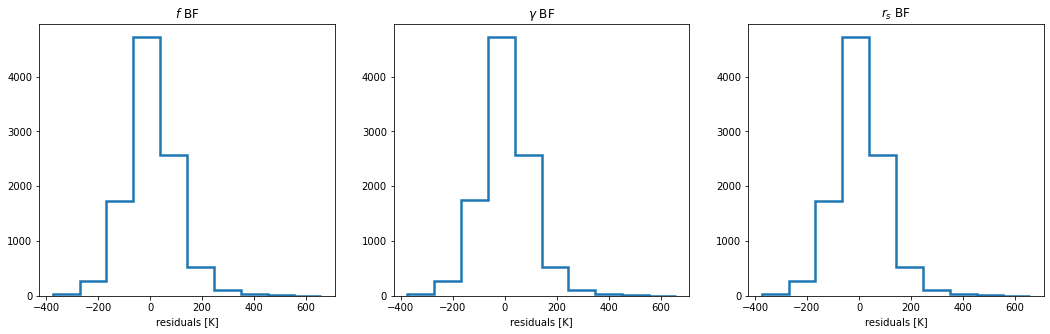

In [11]:
for k in range(5):
    
    #np.random.seed(21)
    robs, Tobs, sigmaTobs, mass, ages = mock_population_all(10000, relT, 0.1, 0.1, 0.1, f_true, gamma_true, 
                                                            rs_true, rho0_true=rho0) 
    
    # Load theoretical cooling model
    path = "./data/"                                                                
    data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)            
    points = np.transpose(data[0:2, :])                                             
    values = data[2]  
    # calculate predictic intrinsic heat flow for mock BDs                         
    xi = np.transpose(np.asarray([ages, mass]))                                     
    Teff     = griddata(points, values, xi)                                         
    heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
    
    Npoints = 100
    
    f          = np.linspace(0, 1.5, Npoints)
    gamma      = np.linspace(0, 2., Npoints)
    rs         = np.linspace(5., 50., Npoints)
    
    like_f     = np.zeros(Npoints)
    like_gamma = np.zeros(Npoints)
    like_rs    = np.zeros(Npoints)
    
    for i in range(Npoints):
        like_f[i]     = residual([f[i], gamma_true, rs_true], robs, Tobs, sigmaTobs, heat_int, mass)
        like_gamma[i] = residual([f_true, gamma[i], rs_true], robs, Tobs, sigmaTobs, heat_int, mass)
        like_rs[i]   = residual([f_true, gamma_true, rs[i]], robs, Tobs, sigmaTobs, heat_int, mass)
    
    f_ML     = f[np.argmax(like_f)]
    gamma_ML = gamma[np.argmax(like_gamma)]
    rs_ML    = rs[np.argmax(like_rs)]
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    ax[0].set_title("$f$ BF")     
    Tmodel = temperature_withDM(robs, heat_int, f=f_ML, M=mass*M_sun.value, 
                                parameters=[gamma_true, rs_true, 0.42]) 
    ax[0].hist((Tobs-Tmodel), histtype="step", linewidth=2.5);
    ax[0].set_xlabel("residuals [K]")
    
    ax[1].set_title("$\gamma$ BF")
    Tmodel = temperature_withDM(robs, heat_int, f=f_true, M=mass*M_sun.value, 
                                parameters=[gamma_ML, rs_true, 0.42]) 
    ax[1].hist((Tobs-Tmodel), histtype="step", linewidth=2.5);
    ax[1].set_xlabel("residuals [K]")
    
    ax[2].set_title("$r_s$ BF")
    Tmodel = temperature_withDM(robs, heat_int, f=f_true, M=mass*M_sun.value, 
                                parameters=[gamma_true, rs_ML, 0.42]) 
    ax[2].hist((Tobs-Tmodel), histtype="step", linewidth=2.5);
    ax[2].set_xlabel("residuals [K]")

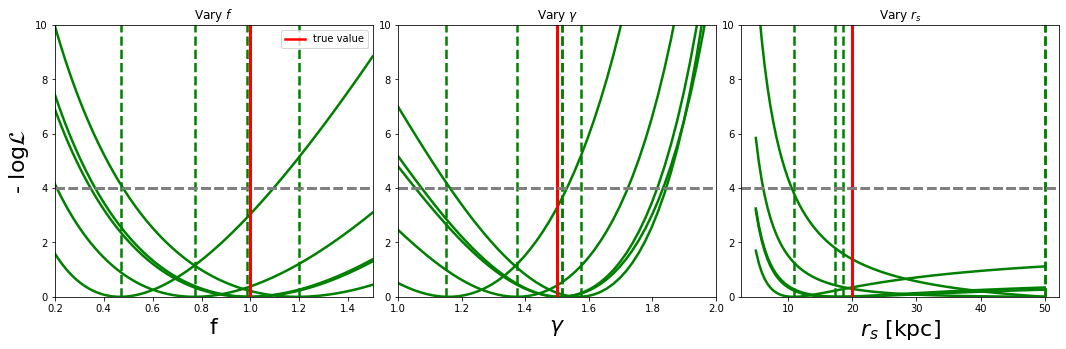

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for k in range(5):
    
    #np.random.seed(21)
    robs, Tobs, sigmaTobs, mass, ages = mock_population_all(nBDs, 0.3, 0.3, 0.3, 0.3, f_true, gamma_true, 
                                                            rs_true, rho0_true=rho0) 
    
    # Load theoretical cooling model
    path = "./data/"                                                                
    data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)            
    points = np.transpose(data[0:2, :])                                             
    values = data[2]  
    # calculate predictic intrinsic heat flow for mock BDs                         
    xi = np.transpose(np.asarray([ages, mass]))                                     
    Teff     = griddata(points, values, xi)                                         
    heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
    
    Npoints = 100
    
    ax[0].set_title("Vary $f$")
    f      = np.linspace(0, 1.5, Npoints)
    like_f = np.zeros(Npoints)
    for i in range(Npoints):
        like_f[i] = residual([f[i], gamma_true, rs_true], robs, Tobs, sigmaTobs, heat_int, mass)
    ax[0].plot(f, -like_f+np.max(like_f), color="green", lw=2.5); ax[0].axvline(f[np.argmax(like_f)], color="green", lw=2.5, ls="--")
    ax[0].axvline(f_true, color="red", lw=2.5); ax[0].set_ylim(0, 10); ax[0].set_xlim(0.2, 1.5)
    ax[0].axhline(4, color="grey", ls="--", lw=2.5)
    
    
    ax[1].set_title("Vary $\gamma$")
    gamma      = np.linspace(0, 2., Npoints)
    like_gamma = np.zeros(Npoints)
    for i in range(Npoints):
        like_gamma[i] = residual([f_true, gamma[i], rs_true], robs, Tobs, sigmaTobs, heat_int, mass)
    ax[1].plot(gamma, -like_gamma+np.max(like_gamma), color="green", lw=2.5); 
    ax[1].axvline(gamma[np.argmax(like_gamma)], color="green", lw=2.5, ls="--"); 
    ax[1].axvline(gamma_true, color="red", lw=2.5); ax[1].set_ylim(0, 10); ax[1].set_xlim(1., 2.)
    ax[1].axhline(4, color="grey", ls="--", lw=2.5)
    
    ax[2].set_title("Vary $r_s$")
    rs      = np.linspace(5., 50., Npoints)
    like_rs = np.zeros(Npoints)
    for i in range(Npoints):
        like_rs[i] = residual([f_true, gamma_true, rs[i]], robs, Tobs, sigmaTobs, heat_int, mass)
    ax[2].plot(rs, -like_rs+np.max(like_rs), color="green", lw=2.5); 
    ax[2].axvline(rs[np.argmax(like_rs)], color="green", lw=2.5, ls="--"); 
    ax[2].axvline(rs_true, color="red", lw=2.5); ax[2].set_ylim(0, 10)
    ax[2].axhline(4, color="grey", ls="--", lw=2.5)
    
ax[0].axvline(f_true, color="red", lw=2.5, label="true value")
ax[0].legend()
ax[0].set_ylabel(r"- log$\mathcal{L}$", fontsize=22)
ax[0].set_xlabel("f", fontsize=22)
ax[1].set_xlabel(r"$\gamma$", fontsize=22)
ax[2].set_xlabel(r"$r_s$ [kpc]", fontsize=22)
fig.subplots_adjust(wspace=0.08)

fig.savefig("logL_relT0.30_relX0.3.pdf", bbox_inches="tight")

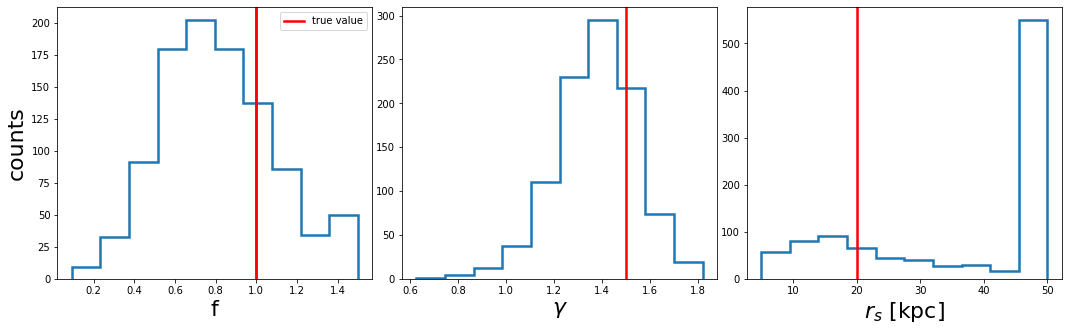

In [35]:
f_ML, gamma_ML, rs_ML = np.genfromtxt("../python/checks/check_likelihood_unc0.3.dat", unpack=True)
    
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].hist(f_ML, histtype="step", linewidth=2.5); ax[1].hist(gamma_ML, histtype="step", linewidth=2.5); 
ax[2].hist(rs_ML, histtype="step", linewidth=2.5);
ax[0].axvline(f_true, color="red", lw=2.5); ax[1].axvline(gamma_true, color="red", lw=2.5);
ax[2].axvline(rs_true, color="red", lw=2.5);

ax[0].axvline(f_true, color="red", lw=2.5, label="true value")
ax[0].legend()
ax[0].set_ylabel(r"counts", fontsize=22)
ax[0].set_xlabel("f", fontsize=22)
ax[1].set_xlabel(r"$\gamma$", fontsize=22)
ax[2].set_xlabel(r"$r_s$ [kpc]", fontsize=22)
fig.subplots_adjust(wspace=0.095)

fig.savefig("histML_relT0.30_relX0.3.pdf", bbox_inches="tight")

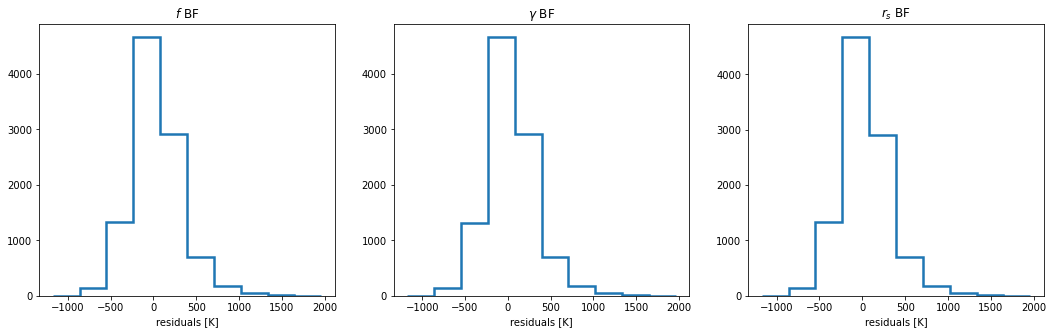

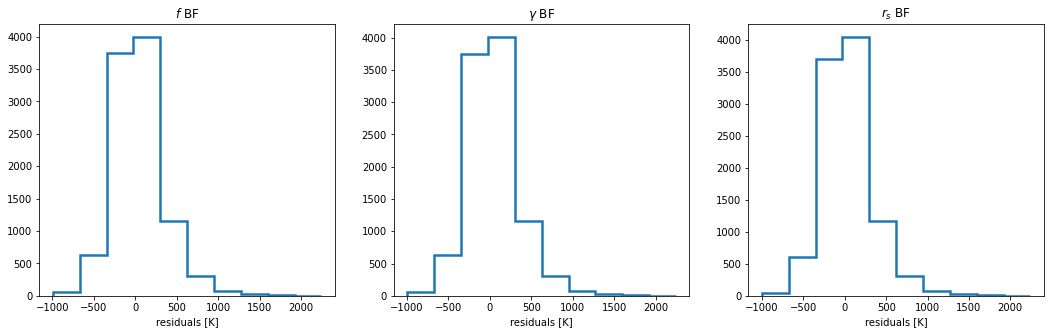

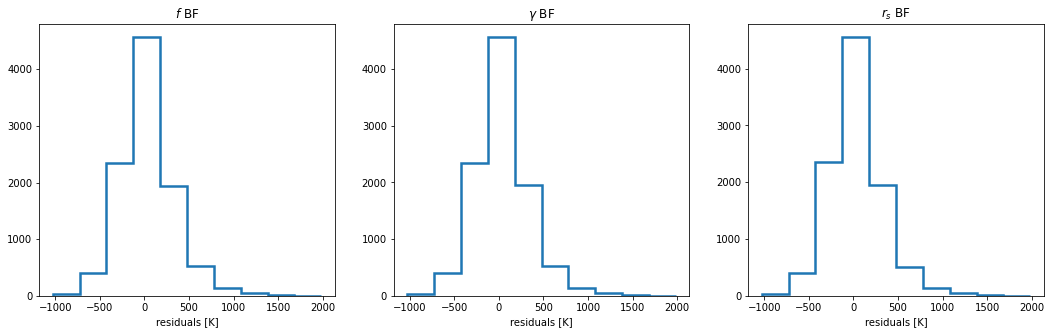

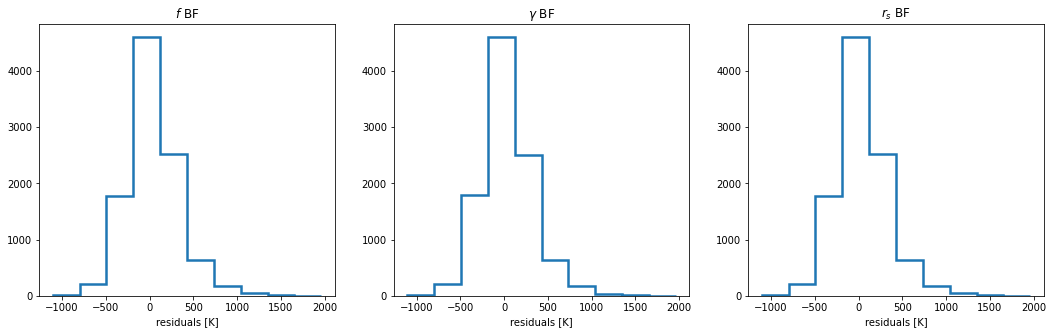

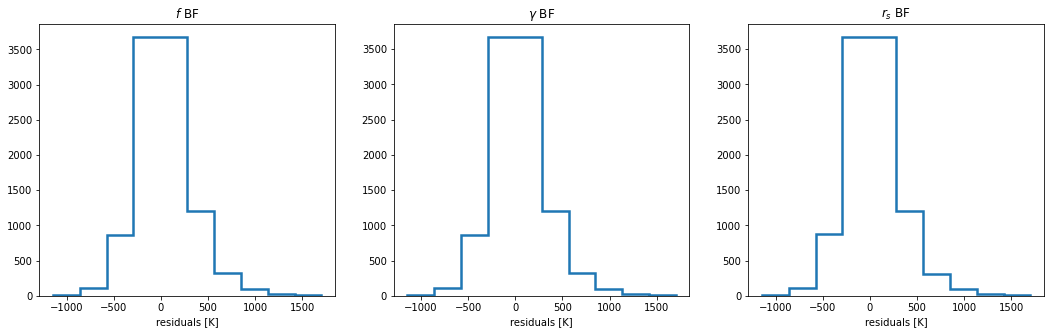

In [32]:
for k in range(5):
    
    #np.random.seed(21)
    robs, Tobs, sigmaTobs, mass, ages = mock_population_all(10000, 0.3, 0.3, 0.3, 0.3, f_true, gamma_true, 
                                                            rs_true, rho0_true=rho0) 
    
    # Load theoretical cooling model
    path = "./data/"                                                                
    data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)            
    points = np.transpose(data[0:2, :])                                             
    values = data[2]  
    # calculate predictic intrinsic heat flow for mock BDs                         
    xi = np.transpose(np.asarray([ages, mass]))                                     
    Teff     = griddata(points, values, xi)                                         
    heat_int = heat(Teff, np.ones(len(Teff))*R_jup.value)
    
    Npoints = 100
    
    f          = np.linspace(0, 1.5, Npoints)
    gamma      = np.linspace(0, 2., Npoints)
    rs         = np.linspace(5., 50., Npoints)
    
    like_f     = np.zeros(Npoints)
    like_gamma = np.zeros(Npoints)
    like_rs    = np.zeros(Npoints)
    
    for i in range(Npoints):
        like_f[i]     = residual([f[i], gamma_true, rs_true], robs, Tobs, sigmaTobs, heat_int, mass)
        like_gamma[i] = residual([f_true, gamma[i], rs_true], robs, Tobs, sigmaTobs, heat_int, mass)
        like_rs[i]   = residual([f_true, gamma_true, rs[i]], robs, Tobs, sigmaTobs, heat_int, mass)
    
    f_ML     = f[np.argmax(like_f)]
    gamma_ML = gamma[np.argmax(like_gamma)]
    rs_ML    = rs[np.argmax(like_rs)]
    
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))
    
    ax[0].set_title("$f$ BF")     
    Tmodel = temperature_withDM(robs, heat_int, f=f_ML, M=mass*M_sun.value, 
                                parameters=[gamma_true, rs_true, 0.42]) 
    ax[0].hist((Tobs-Tmodel), histtype="step", linewidth=2.5);
    ax[0].set_xlabel("residuals [K]")
    
    ax[1].set_title("$\gamma$ BF")
    Tmodel = temperature_withDM(robs, heat_int, f=f_true, M=mass*M_sun.value, 
                                parameters=[gamma_ML, rs_true, 0.42]) 
    ax[1].hist((Tobs-Tmodel), histtype="step", linewidth=2.5);
    ax[1].set_xlabel("residuals [K]")
    
    ax[2].set_title("$r_s$ BF")
    Tmodel = temperature_withDM(robs, heat_int, f=f_true, M=mass*M_sun.value, 
                                parameters=[gamma_true, rs_ML, 0.42]) 
    ax[2].hist((Tobs-Tmodel), histtype="step", linewidth=2.5);
    ax[2].set_xlabel("residuals [K]")

## Modifying the likelihood function : include "effective" uncertainty in T

In [15]:
from utils import gNFW_rho, vc
from astropy.constants import R_jup, M_jup, G, sigma_sb
import astropy.units as u

**Analytical derivatives**

In [96]:
_sigma_sb = sigma_sb.value
_G        = G.value

def derivativeTDM_wrt_M(r, f=1, R=R_jup.value, M=M_jup.value, 
                        parameters=[1., 20., 0.42], v=None, epsilon=1):
    """
    Return derivative of DM temperature wrt mass @ (f, gamma, rs, rho0, r, M, R) [K/kg]
    """
    # escape velocity
    vesc   = np.sqrt(2*_G*M/R)*1e-3 # km/s
    if v:
        _vD = v
        #print(_vD, "here i am")
    else:
        _vD    = np.sqrt(3/2.)*vc(Rsun, r, parameters) # km/s
        
    _vDM   =  np.sqrt(8./(3*np.pi))*_vD # km/s
    _rhoDM = gNFW_rho(Rsun, r, parameters) # GeV/cm3

    conversion_into_w = 0.16021766 
    
    # DM temperature^-3 [1/K^3]
    T_DM3 = np.power((f*_rhoDM*_vDM*(1+3./2.*np.power(vesc/_vD, 2))*
                     conversion_into_w)/(4*_sigma_sb*epsilon), -3./4.)
    
    #print(T_DM3)
    
    conversion_into_K_vs_kg = 1.60217e-7
    # return 
    return (T_DM3*3./16.*np.sqrt(8./3./np.pi)*f/_sigma_sb/epsilon*_rhoDM*_G/_vD/R*
            conversion_into_K_vs_kg
           )


def derivativeTDM_wrt_r(r, f=1, R=R_jup.value, M=M_jup.value, 
                        parameters=[1., 20., 0.42], v=None, epsilon=1):
    """
    Return derivative of DM temperature wrt r @ (f, gamma, rs, rho0, r, M, R) [K/kpc]
    
    Assumption: DM velocity and velocity dispersion constant!
    """
    # escape velocity
    vesc   = np.sqrt(2*_G*M/R)*1e-3 # km/s
    if v:
        _vD = v
        #print(_vD, "here i am")
    else:
        _vD    = np.sqrt(3/2.)*vc(Rsun, r, parameters) # km/s
        
    _vDM   =  np.sqrt(8./(3*np.pi))*_vD # km/s
    _rhoDM = gNFW_rho(Rsun, r, parameters) # GeV/cm3

    conversion_into_w = 0.16021766 
    
    # DM temperature [K]
    T_DM = np.power((f*_rhoDM*_vDM*(1+3./2.*np.power(vesc/_vD, 2))*
                     conversion_into_w)/(4*_sigma_sb*epsilon), 1./4.)
    
    return(0.25*T_DM*(-parameters[0]/r - (3-parameters[0])/(parameters[1] + r))
           )

**Numerical derivatives**

In [103]:
from scipy.interpolate import griddata, interp1d
from scipy.misc import derivative

# load theoretical BD cooling model - ATMO 2020
path =  "./data/"
data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]

def derivativeTint_wrt_A(M, A, points, values, size=7000, h=0.001):
    """
    Return derivative of intrinsic temperature wrt Age [K/Gyr]
    
    Input
    -----
        M : mass [Msun]
        A : age [Gyr]
    """   
    ages   = np.linspace(1., 10., size)
    mass   = np.ones(size)*M
    xi     = np.transpose(np.asarray([ages, mass]))
    Teff   = griddata(points, values, xi)
    # return
    return derivative(interp1d(ages, Teff), A, dx=h)

Checking the derivative

In [141]:
M      = np.linspace(0.013, 0.053, 4)
ages   = np.linspace(1.002, 9.998, 500)
ls     = ["-", "--", ":"]
color  = ["blue", "red", "green", "orange"]

size_baseline = 7000
h_baseline    = 1e-3

dev_baseline = {}
for m in M:
    dev_baseline[m] = derivativeTint_wrt_A(m, ages, points, values, size=size_baseline, h=h_baseline)

Text(0.5, 0, 'ages [Gyr]')

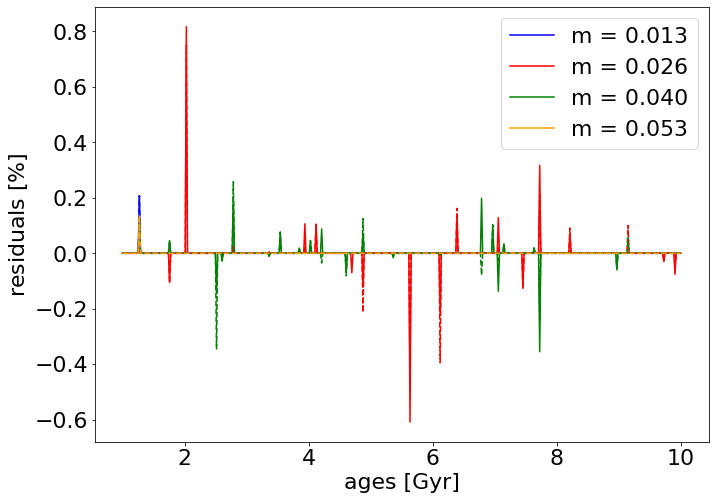

In [142]:
h = 0.001

# Effect of size
fig, ax = plt.subplots(1, 1, figsize=(11, 8))

j = 0
for s in [10000, 15000]:
    i = 0
    for m in M:
        dev = derivativeTint_wrt_A(m, ages, points, values, size=s, h=h_baseline)
        if j==0:
            ax.plot(ages, (dev-dev_baseline[m])/dev_baseline[m]*100, color=color[i], ls=ls[j], label="m = %.3f"%m)
        else:
            ax.plot(ages, (dev-dev_baseline[m])/dev_baseline[m]*100, color=color[i], ls=ls[j])
        i+=1
    j+=1
ax.legend()
ax.set_ylabel("residuals [$\%$]"); ax.set_xlabel("ages [Gyr]")

Text(0.5, 0, 'ages [Gyr]')

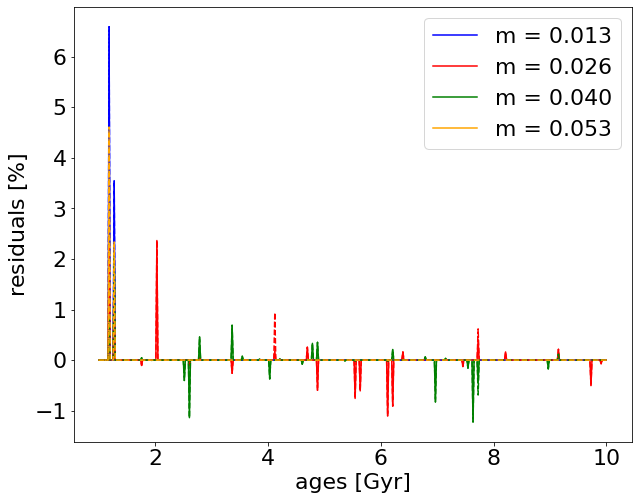

In [143]:
size   = 7000
method = "central"
# Effect of h
fig, ax = plt.subplots(1, 1, figsize=(10, 8))


j = 0
for h in [1e-4, 1e-5]:
    i = 0
    for m in M:
        dev = derivativeTint_wrt_A(m, ages, points, values, size=size_baseline, h=h)
        if j==0:
            ax.plot(ages, (dev-dev_baseline[m])/dev_baseline[m]*100, color=color[i], ls=ls[j], 
                    label="m = %.3f"%m)
        else:
            ax.plot(ages, (dev-dev_baseline[m])/dev_baseline[m]*100, color=color[i], ls=ls[j])
        i+=1
    j+=1
ax.legend()
ax.set_ylabel("residuals [$\%$]"); ax.set_xlabel("ages [Gyr]")

In [144]:
def derivativeTint_wrt_M(M, A, points, values, size=7000, h=0.001):
    """
    Return derivative of intrinsic temperature wrt Age [K/Gyr]
    
    Input
    -----
        M : mass [Msun]
        A : age [Gyr]
    """   
    ages   = np.ones(size)*A
    mass   = np.linspace(0.013, 0.053, size)
    xi     = np.transpose(np.asarray([ages, mass]))
    Teff   = griddata(points, values, xi)
    # return
    return derivative(interp1d(mass, Teff), M, dx=h)

Checking the derivative

In [145]:
M      = np.linspace(0.015, 0.051, 500)
ages   = np.linspace(1., 10., 4)
ls     = ["-", "--", ":"]
color  = ["blue", "red", "green", "orange"]

size_baseline = 7000
h_baseline    = 1e-3

dev_baseline = {}
for A in ages:
    dev_baseline[A] = derivativeTint_wrt_M(M, A, points, values, size=size_baseline, h=h_baseline)

Text(0.5, 0, 'mass [Msun]')

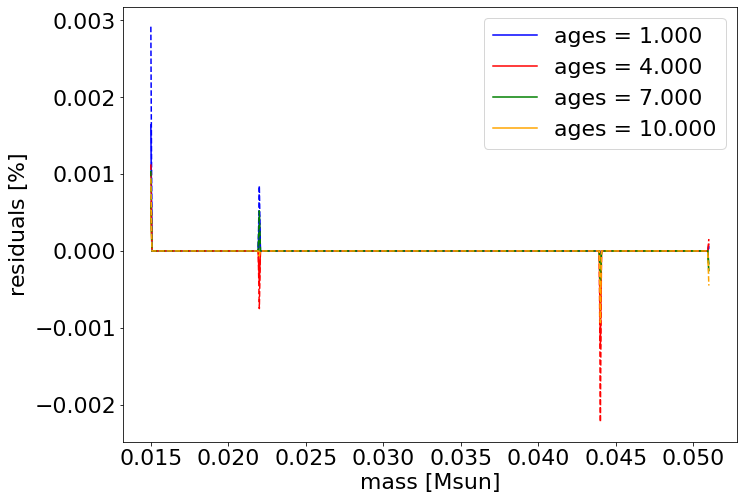

In [148]:
h = 0.001

# Effect of size
fig, ax = plt.subplots(1, 1, figsize=(11, 8))

j = 0
for s in [10000, 15000]:
    i = 0
    for A in ages:
        dev = derivativeTint_wrt_M(M, A, points, values, size=s, h=h_baseline)
        if j==0:
            ax.plot(M, (dev-dev_baseline[A])/dev_baseline[A]*100, color=color[i], ls=ls[j], label="ages = %.3f"%A)
        else:
            ax.plot(M, (dev-dev_baseline[A])/dev_baseline[A]*100, color=color[i], ls=ls[j])
        i+=1
    j+=1
ax.legend()
ax.set_ylabel("residuals [$\%$]"); ax.set_xlabel("mass [Msun]")

Text(0.5, 0, 'mass [Msun]')

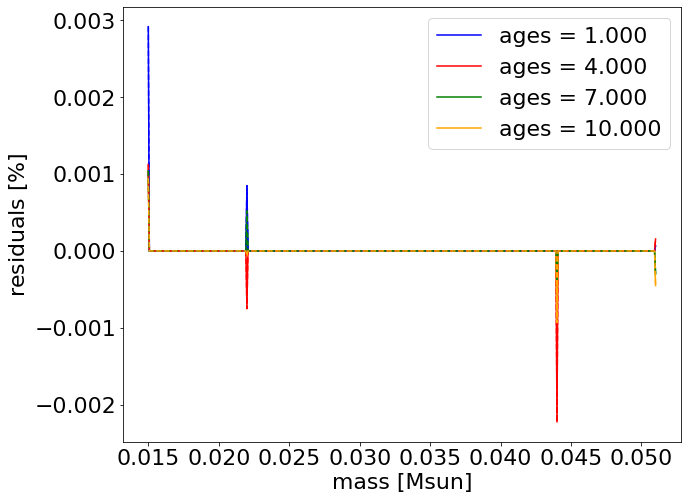

In [149]:
size   = 7000
method = "central"
# Effect of h
fig, ax = plt.subplots(1, 1, figsize=(10, 8))


j = 0
for h in [1e-4, 1e-5]:
    i = 0
    for A in ages:
        dev = derivativeTint_wrt_M(M, A, points, values, size=s, h=h_baseline)
        if j==0:
            ax.plot(M, (dev-dev_baseline[A])/dev_baseline[A]*100, color=color[i], ls=ls[j], label="ages = %.3f"%A)
        else:
            ax.plot(M, (dev-dev_baseline[A])/dev_baseline[A]*100, color=color[i], ls=ls[j])
        i+=1
    j+=1
ax.legend()
ax.set_ylabel("residuals [$\%$]"); ax.set_xlabel("mass [Msun]")

In [9]:
import imp
import derivatives
imp.reload(derivatives)
from derivatives import derivativeTDM_wrt_M, derivativeTDM_wrt_r, derivativeTint_wrt_A, derivativeTint_wrt_M


In [11]:
print(derivativeTDM_wrt_r(0.8))
print(derivativeTDM_wrt_M(0.8))

-60.24196886379066
3.710390955234692e-27


**Numerical derivatives**

In [13]:
# load theoretical BD cooling model - ATMO 2020
path =  "./data/"
data = np.genfromtxt(path + "./ATMO_CEQ_vega_MIRI.txt", unpack=True)
points = np.transpose(data[0:2, :])
values = data[2]

Checking the derivative

In [14]:
M      = np.linspace(0.013, 0.053, 4)
ages   = np.linspace(1.002, 9.998, 500)
ls     = ["-", "--", ":"]
color  = ["blue", "red", "green", "orange"]

size_baseline = 7000
h_baseline    = 1e-3

dev_baseline = {}
for m in M:
    dev_baseline[m] = derivativeTint_wrt_A(m, ages, points, values, size=size_baseline, h=h_baseline)

Text(0.5, 0, 'ages [Gyr]')

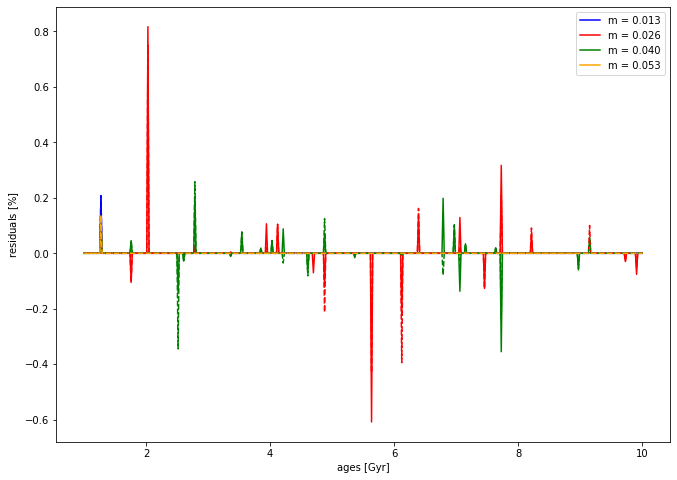

In [15]:
h = 0.001

# Effect of size
fig, ax = plt.subplots(1, 1, figsize=(11, 8))

j = 0
for s in [10000, 15000]:
    i = 0
    for m in M:
        dev = derivativeTint_wrt_A(m, ages, points, values, size=s, h=h_baseline)
        if j==0:
            ax.plot(ages, (dev-dev_baseline[m])/dev_baseline[m]*100, color=color[i], ls=ls[j], label="m = %.3f"%m)
        else:
            ax.plot(ages, (dev-dev_baseline[m])/dev_baseline[m]*100, color=color[i], ls=ls[j])
        i+=1
    j+=1
ax.legend()
ax.set_ylabel("residuals [$\%$]"); ax.set_xlabel("ages [Gyr]")

Text(0.5, 0, 'ages [Gyr]')

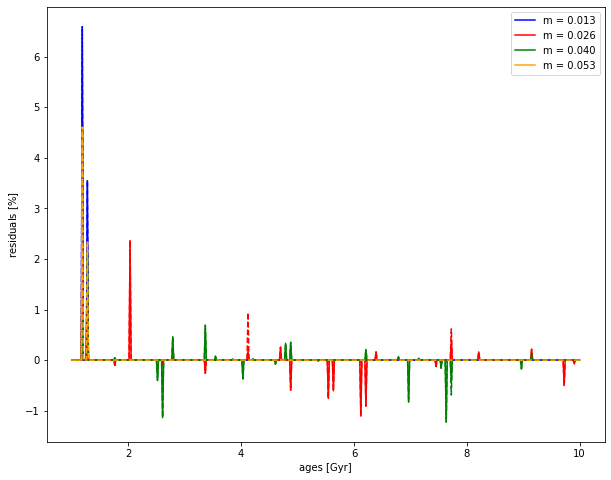

In [16]:
size   = 7000
method = "central"
# Effect of h
fig, ax = plt.subplots(1, 1, figsize=(10, 8))


j = 0
for h in [1e-4, 1e-5]:
    i = 0
    for m in M:
        dev = derivativeTint_wrt_A(m, ages, points, values, size=size_baseline, h=h)
        if j==0:
            ax.plot(ages, (dev-dev_baseline[m])/dev_baseline[m]*100, color=color[i], ls=ls[j], 
                    label="m = %.3f"%m)
        else:
            ax.plot(ages, (dev-dev_baseline[m])/dev_baseline[m]*100, color=color[i], ls=ls[j])
        i+=1
    j+=1
ax.legend()
ax.set_ylabel("residuals [$\%$]"); ax.set_xlabel("ages [Gyr]")

Checking the derivative

In [17]:
M      = np.linspace(0.015, 0.051, 500)
ages   = np.linspace(1., 10., 4)
ls     = ["-", "--", ":"]
color  = ["blue", "red", "green", "orange"]

size_baseline = 7000
h_baseline    = 1e-3

dev_baseline = {}
for A in ages:
    dev_baseline[A] = derivativeTint_wrt_M(M, A, points, values, size=size_baseline, h=h_baseline)

Text(0.5, 0, 'mass [Msun]')

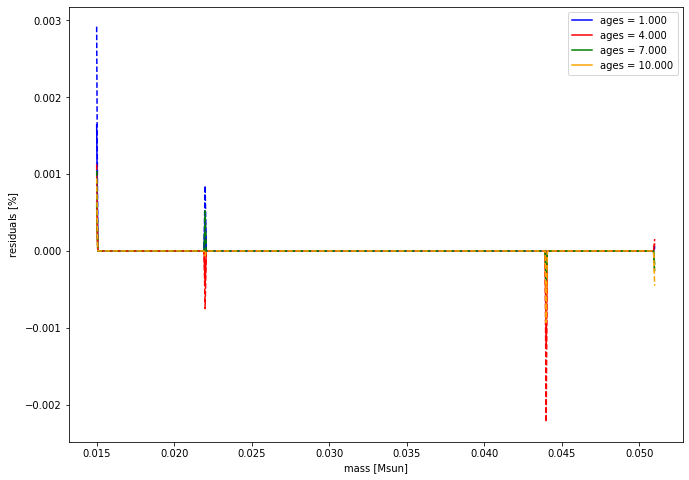

In [18]:
h = 0.001

# Effect of size
fig, ax = plt.subplots(1, 1, figsize=(11, 8))

j = 0
for s in [10000, 15000]:
    i = 0
    for A in ages:
        dev = derivativeTint_wrt_M(M, A, points, values, size=s, h=h_baseline)
        if j==0:
            ax.plot(M, (dev-dev_baseline[A])/dev_baseline[A]*100, color=color[i], ls=ls[j], label="ages = %.3f"%A)
        else:
            ax.plot(M, (dev-dev_baseline[A])/dev_baseline[A]*100, color=color[i], ls=ls[j])
        i+=1
    j+=1
ax.legend()
ax.set_ylabel("residuals [$\%$]"); ax.set_xlabel("mass [Msun]")

Text(0.5, 0, 'mass [Msun]')

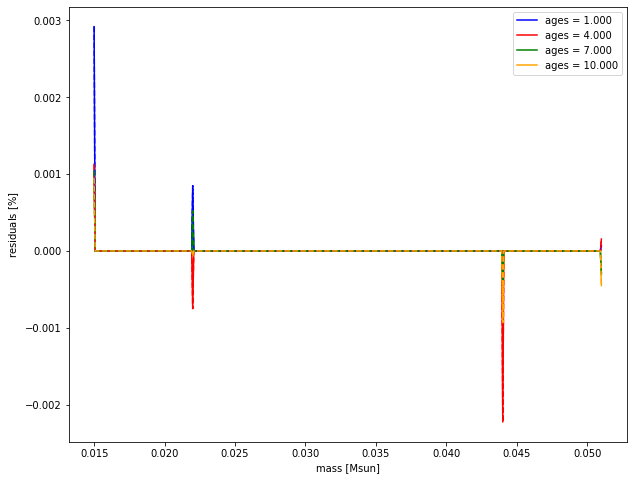

In [19]:
size   = 7000
method = "central"
# Effect of h
fig, ax = plt.subplots(1, 1, figsize=(10, 8))


j = 0
for h in [1e-4, 1e-5]:
    i = 0
    for A in ages:
        dev = derivativeTint_wrt_M(M, A, points, values, size=s, h=h_baseline)
        if j==0:
            ax.plot(M, (dev-dev_baseline[A])/dev_baseline[A]*100, color=color[i], ls=ls[j], label="ages = %.3f"%A)
        else:
            ax.plot(M, (dev-dev_baseline[A])/dev_baseline[A]*100, color=color[i], ls=ls[j])
        i+=1
    j+=1
ax.legend()
ax.set_ylabel("residuals [$\%$]"); ax.set_xlabel("mass [Msun]")